In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os 

## A basic dataset class for PUG: ImageNet

In [ ]:
PUG_IMAGENET_PATH = os.path.expandvars('$SCRATCH/PUG_ImageNet/')

class UnrealDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.df.astype(str)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getIndicesByFactors__(self, world_name="City", character_label="GoldFish", character_scale=1.0, character_texture='Default', camera_yaw=0):
        indices = dataset.df[#(dataset.df['world_name'] == world_name)
                            (dataset.df['character_label'] == character_label)]                            
        return indices.index.values
    
    def __getitem__(self, index):
        filename = self.df['filename'][index]
        label = self.df['character_label'][index]
        image = Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, self.df['world_name'][index], self.df['character_label'][index]

dataset = UnrealDataset(csv_path=PUG_IMAGENET_PATH+"/labels_pug_imagenet.csv", images_folder=PUG_IMAGENET_PATH)

## Samples from the PUG: ImageNet dataset

In [ ]:
f, axarr = plt.subplots(8,8, figsize=(16,16))
list_world_names = dataset.df["world_name"].unique().tolist()
list_characters_names = dataset.df["character_label"].unique().tolist()
i = 0
j = 0
indexes = dataset.__getIndicesByFactors__(character_label='Chest')
for k in range(64):
    data = dataset.__getitem__(indexes[k])
    img = data[0]
    axarr[j,i%8].axis('off')
    axarr[j,i%8].imshow(img, aspect="auto")
    i = i + 1
    j = int(i / 8)
f.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

# How to run evaluations on PUG: ImageNet

The step below is important since it allows us to convert the 151 Pug:ImageNet labels to the correct label in the real ImageNet dataset (which contains 1000 classes).

In [ ]:
import json

# This is the file that map the PUG: ImageNet class indexes (from 0 to 151) to the real ImageNet classes (up to 1000)
with open(os.path.expandvars('$SCRATCH/PUG_ImageNet/class_to_imagenet_idx.json')) as f:
    labels = json.load(f)
labels = dict(sorted(labels.items()))
# Then we create a disctionary that map an imagenet class to the PUG:ImageNet class
inversed_dict = {}
counter = 0
for k,v in labels.items():
    for val in v:
        inversed_dict[int(val)] = counter
    counter = counter + 1
print(inversed_dict)

### Creating a dataloader

Then we create a dataloader using the PUG: ImageNet worlds subsets (which evaluate the performances accross backgrounds). You can switch the subset from one of the following values:
Worlds, Camera_Pitch, Camera_Yaw,  Camera_Roll, Object_Pitch, Object_Yaw, Object_Roll, Object_Scale, Object_Texture, Scene_Light

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

# Set data transformations
tr_normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
transform_val = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    tr_normalize,
])

# Create dataloaders
val_dataset_world = datasets.ImageFolder(PUG_IMAGENET_PATH+"Worlds/", transform=transform_val)
dataloader = DataLoader(val_dataset_world, batch_size=64, shuffle=False, num_workers=4, drop_last=False)

### Using a pretrained model

In [ ]:
import torchvision
# We use a pretrained resnet50 in this example
model = torchvision.models.resnet50(pretrained=True)
model.eval()
model.cuda()

### Run the evaluation

In [ ]:
list_corrects = []
nb_corrects = 0.
for k, (images, labels) in enumerate(dataloader):
    images = images.cuda()
    labels = labels.cuda()
    with torch.no_grad(), torch.cuda.amp.autocast():
        output = model(images).softmax(dim=-1)
        pred = torch.argmax(output, dim=1)
        # This is used to convert the index predicted by the pretraned model into one of the 151 labels contained in PUG: ImageNet
        for p in range(pred.size(0)):
            if pred[p].item() in inversed_dict.keys():
                pred[p] = inversed_dict[pred[p].item()]
            else:
                pred[p] = 999 # We put random value if the predicted class is not in the 151 labels we are using
        nb_corrects += sum((pred == labels).float())
print("Accuracy: ", (nb_corrects/len(val_dataset_world))*100.)

# Custom

In [1]:
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch
import pandas as pd
from PIL import Image
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score


PUG_IMAGENET_PATH = os.path.expandvars('$SCRATCH/PUG_ImageNet/')
path_results = '../results/PUG/ImageNet/'

model_name = 'ViT-B16'
models_and_weights_imagenet = {
    'ResNet-50': (resnet50, ResNet50_Weights.DEFAULT),
    'ViT-B16': (vit_b_16, ViT_B_16_Weights.DEFAULT), 
}

class UnrealDatasetCustom(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.df.astype(str)
        self.images_folder = images_folder
        self.transform = transform

        with open(os.path.expandvars('$SCRATCH/PUG_ImageNet/class_to_imagenet_idx.json')) as f:
            labels = json.load(f)
        labels = dict(sorted(labels.items()))
        self.classname_to_idx = {}
        for i, k in enumerate(labels.keys()):
            self.classname_to_idx[k] = i

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df['filename'][index]
        label = self.classname_to_idx[self.df['character_label'][index]]
        metadata = self.df.iloc[index].to_dict()
        image = Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, label, metadata

architecture, weights = models_and_weights_imagenet[model_name]
classifier = architecture(weights=weights).eval().cuda()
transforms = weights.transforms()

dataset = UnrealDatasetCustom(csv_path=PUG_IMAGENET_PATH+"/labels_pug_imagenet.csv", images_folder=PUG_IMAGENET_PATH, transform=transforms)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4, drop_last=False)


# This is the file that map the PUG: ImageNet class indexes (from 0 to 151) to the real ImageNet classes (up to 1000)
with open(os.path.expandvars('$SCRATCH/PUG_ImageNet/class_to_imagenet_idx.json')) as f:
    labels = json.load(f)
labels = dict(sorted(labels.items()))
# Then we create a disctionary that map an imagenet class to the PUG:ImageNet class
imagenet_idx_to_pug_idx = {}
counter = 0
for k,v in labels.items():
    for val in v:
        imagenet_idx_to_pug_idx[int(val)] = counter
    counter = counter + 1

classname_to_idx = {}
for i, k in enumerate(labels.keys()):
    classname_to_idx[k] = i

attributes_names = [
    'character_rotation_yaw', 'character_rotation_roll','character_rotation_pitch', 'character_scale', 
    'camera_roll', 'camera_pitch', 'camera_yaw',
    'world_name', 'character_label', 'character_texture', 'scene_light' # categorical
    ]

In [2]:
path_res_file = path_results+f'res_{model_name}.csv'
if os.path.exists(path_res_file):
    df_res = pd.read_csv(path_res_file)
else:
    list_res = []
    for images, labels, metadata in dataloader:
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = classifier(images)
            probas = torch.softmax(logits, axis=1)
        confidences, pred = probas.max(dim=1)
        for i in range(pred.shape[0]):
            if pred[i].item() in imagenet_idx_to_pug_idx.keys():
                pred[i] = imagenet_idx_to_pug_idx[pred[i].item()]
            else:
                pred[i] = 1000 # We put random value if the predicted class is not in the 151 labels we are using
        correct = (pred == labels)
        list_res.append(pd.DataFrame({'confidence': confidences.cpu(), 'prediction': pred.cpu(), 'correct': correct.cpu(), **metadata}))
    df_res = pd.concat(list_res)
    df_res = df_res.reset_index(drop=True)
    df_res.to_csv(path_results+f'res_{model_name}.csv')

avg_confid = df_res['confidence'].mean()
global_acc = df_res['correct'].mean()

df_res

,Unnamed: 0,confidence,prediction,correct,filename,world_name,character_name,character_label,character_rotation_yaw,character_rotation_roll,character_rotation_pitch,character_scale,camera_roll,camera_pitch,camera_yaw,character_texture,scene_light
0,0,0.921646,15,True,Worlds/BirdHouse/000000000.png,Egypt,0025c5e2333949feb1db259d4ff08dbe,BirdHouse,0,0,0,1.0,0,0,0,Default,Default
1,1,0.229786,1000,False,Worlds/Chest/000000001.png,Egypt,046e3307c74746a58ec4bea5b33b7b97,Chest,0,0,0,1.0,0,0,0,Default,Default
2,2,0.780447,1000,False,Worlds/Skirt/000000002.png,Egypt,05590035d2954909ab287208a42da45a,Skirt,0,0,0,1.0,0,0,0,Default,Default
3,3,0.299091,1000,False,Worlds/Bagel/000000003.png,Egypt,c2f9b76e6b184138a23dfda89829fa8b,Bagel,0,0,0,1.0,0,0,0,Default,Default
4,4,0.241478,1000,False,Worlds/WarPlane/000000005.png,Egypt,eb130fcd003b4094aef0b7ea127d41c2,WarPlane,0,0,0,1.0,0,0,0,Default,Default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88323,3,0.908382,1000,False,Scene_Light/Stonewall/000090595.png,Opera,ce09bdd842f84efe9ddd1623828dc016,Stonewall,0,0,0,0.7,0,0,0,Default,"0,255,0,0"
88324,4,0.884832,1000,False,Scene_Light/Stonewall/000090596.png,Opera,ce09bdd842f84efe9ddd1623828dc016,Stonewall,0,0,0,0.7,0,0,0,Default,"255,0,0,0"
88325,5,0.911062,1000,False,Scene_Light/Stonewall/000090597.png,Opera,ce09bdd842f84efe9ddd1623828dc016,Stonewall,0,0,0,0.7,0,0,0,Default,"0,255,255,0"
88326,6,0.898729,1000,False,Scene_Light/Stonewall/000090598.png,Opera,ce09bdd842f84efe9ddd1623828dc016,Stonewall,0,0,0,0.7,0,0,0,Default,"255,0,255,0"


In [3]:
for a in attributes_names:
    print(a, df_res[a].unique())

character_rotation_yaw [  0  45  90 135 180 225 270]
character_rotation_roll [  0  45  90 135 180 225 270]
character_rotation_pitch [  0  45  90 135 180 225 270]
character_scale [1.  0.5 0.6 0.7 0.8 1.3 1.6]
camera_roll [  0  45  90 135 180 225 270]
camera_pitch [  0 320 240 260 280 300 340]
camera_yaw [  0  45 135 180 225 270]
world_name ['Egypt' 'Desert' 'AmusementPark' 'ArcadeClub' 'Arena' 'Battleground'
 'Catacombs' 'Tableland' 'EuropeanStreet' 'JunkYard' 'OceanFloor'
 'Racetrack' 'Ruins' 'SciFiCity' 'SciFiGarage' 'SpaceIsland' 'SpaceHangar'
 'SpatialStation' 'TokyoDay' 'TokyoNight' 'TrainStation' 'Bridge' 'Beach'
 'BusStationInterior' 'BusStationExterior' 'Subway' 'IndoorStairs' 'Bar'
 'ScreeningCheckpoint' 'Circus' 'Appartment' 'Hallway' 'TrashRoom'
 'FuturisticSubway' 'Footbridge' 'BoxingRing' 'Hangar' 'Mansion'
 'ShoppingMall' 'ConferenceRoom' 'SpacePort' 'VillageOutskirt'
 'VillageSquare' 'Courtyard' 'ElvenRuins' 'Forge' 'Library' 'Museum'
 'Gallery' 'ModernGallery' 'Opera' 'A

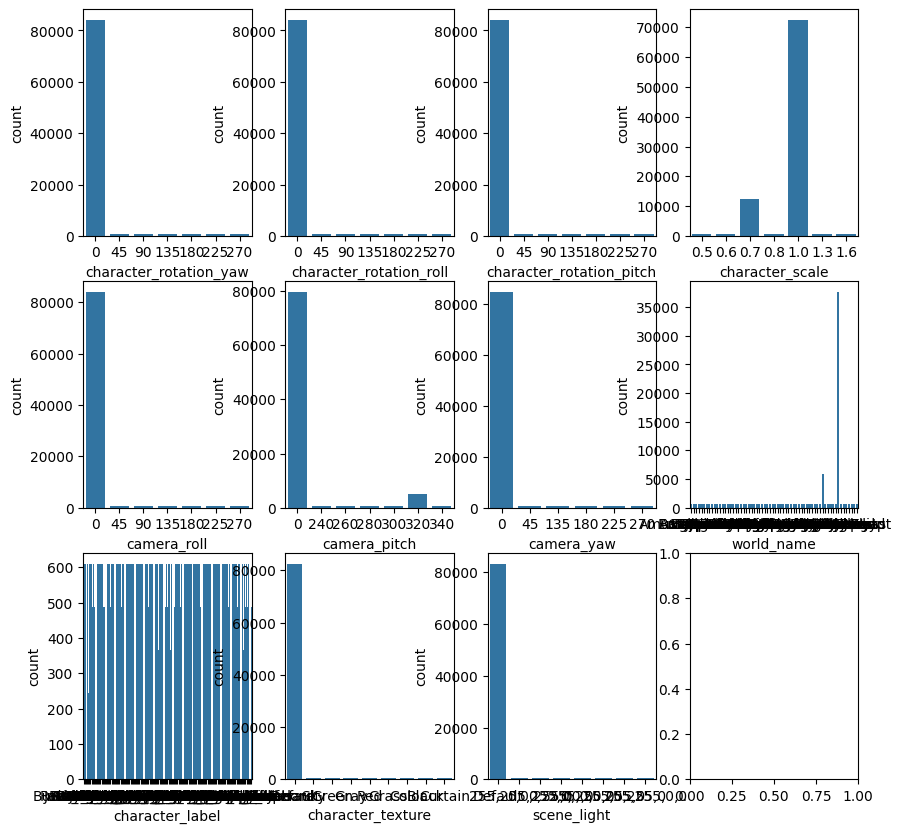

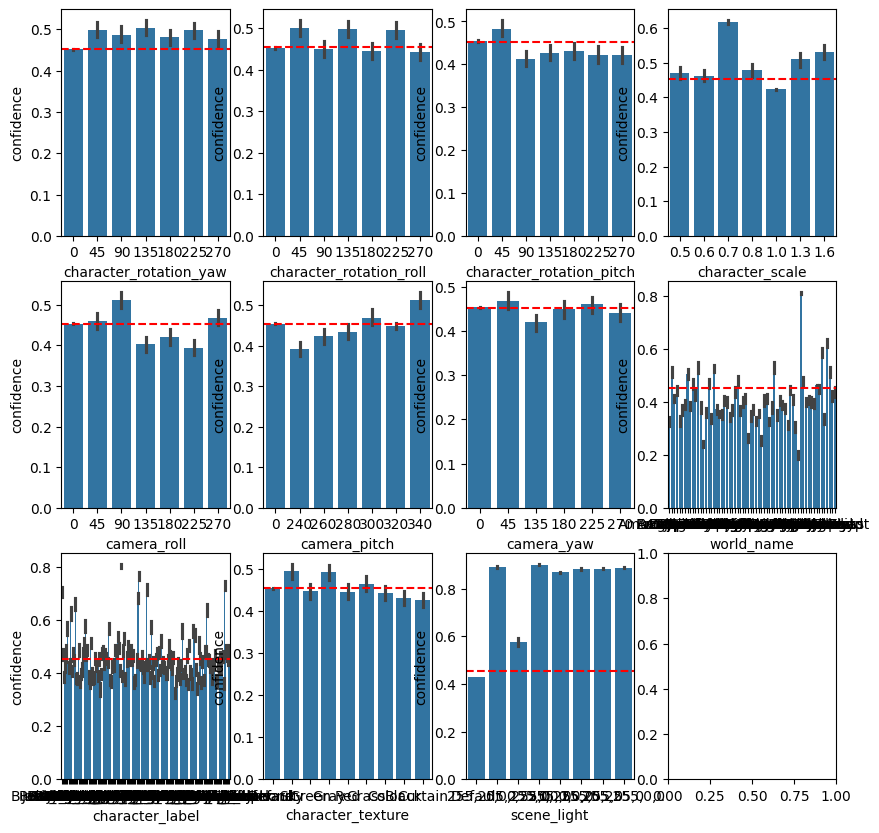

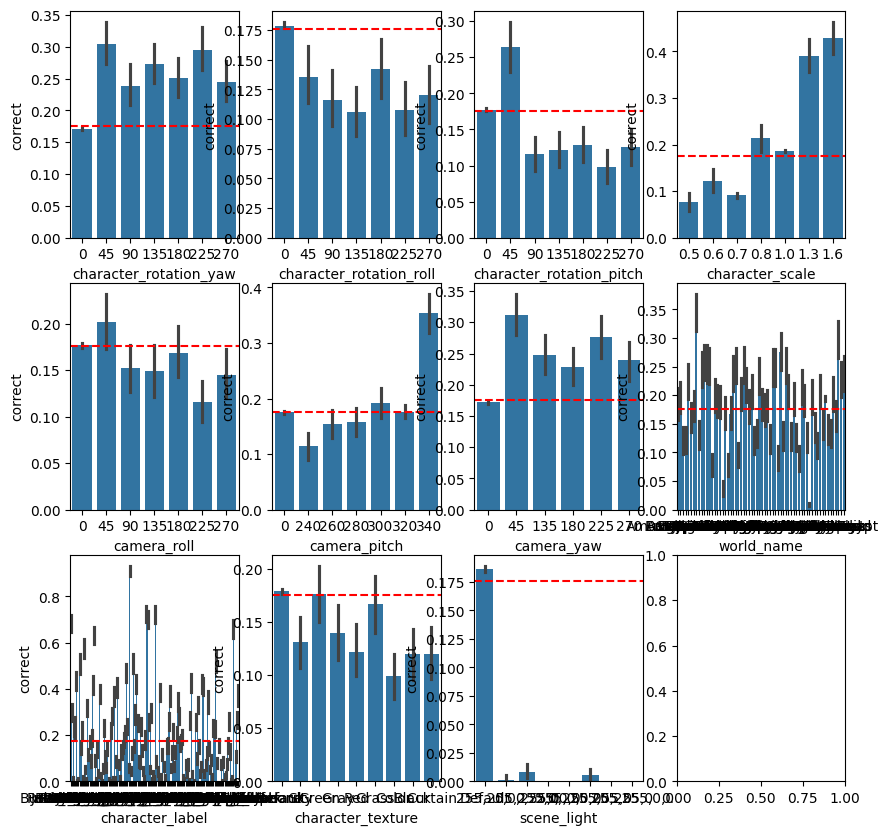

In [4]:
fig, axs = plt.subplots(3, 4, figsize=(10, 10))
for i, attribute in enumerate(attributes_names):
    sns.countplot(df_res, x=attribute, ax=axs.flatten()[i])

fig, axs = plt.subplots(3, 4, figsize=(10, 10))
for i, attribute in enumerate(attributes_names):
    sns.barplot(df_res, x=attribute, y='confidence', ax=axs.flatten()[i])
    axs.flatten()[i].axhline(y=avg_confid, color='r', linestyle='--', label='Average Confidence')

fig, axs = plt.subplots(3, 4, figsize=(10, 10))
for i, attribute in enumerate(attributes_names):
    sns.barplot(df_res, x=attribute, y='correct', ax=axs.flatten()[i])
    axs.flatten()[i].axhline(y=global_acc, color='r', linestyle='--', label='Global Accuracy')

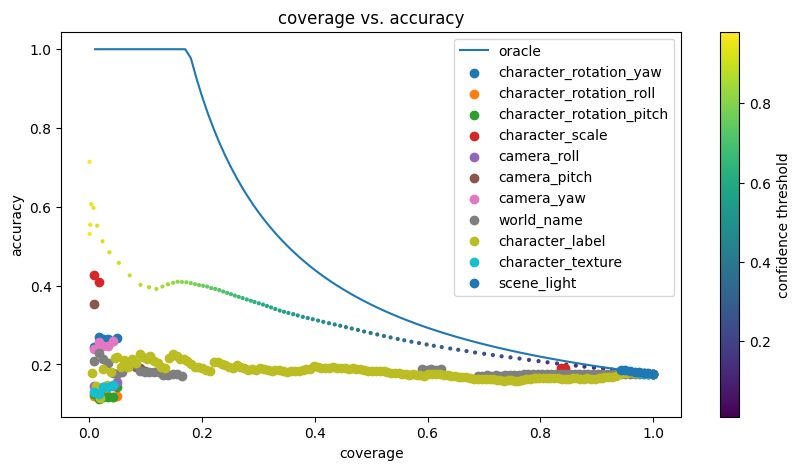

In [6]:
domain_cutoff_baseline = np.linspace(0.01, 1, 100)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_res['confidence'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_res[idx_domain]['correct'].mean()

domain_cutoff_oracle = np.linspace(0.01, 1, 100)
coverage_oracle = np.zeros_like(domain_cutoff_oracle)
acc_oracle = np.zeros_like(domain_cutoff_oracle)
df_res.sort_values(by='correct', ascending=False)
for i, cut in enumerate(domain_cutoff_oracle):
    idx_domain = df_res.sort_values(by='correct', ascending=False).index[:int(cut*len(df_res))]
    coverage_oracle[i] = cut
    acc_oracle[i] = df_res.iloc[idx_domain]['correct'].mean()
    

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')
ax1.plot(coverage_oracle, acc_oracle, label='oracle')
sc = ax1.scatter(coverage_baseline, acc_baseline, c=domain_cutoff_baseline, cmap='viridis', s=4)
fig.colorbar(sc, ax=ax1, label='confidence threshold')



for attribute in attributes_names:
    # attribute = 'character_name'
    dict_attrib_acc = {}
    for k in df_res[attribute].unique():
        dict_attrib_acc[k] = df_res.loc[df_res[attribute] == k, 'correct'].mean()
    dict_attrib_acc = {k: dict_attrib_acc[k] for k in sorted(dict_attrib_acc, reverse=True)}

    coverage = np.zeros(len(dict_attrib_acc))
    acc = np.zeros(len(dict_attrib_acc))
    df_res.sort_values(by='correct', ascending=False)
    for i, k in enumerate(dict_attrib_acc.keys()):
        idx_domain = df_res[attribute].isin(list(dict_attrib_acc.keys())[:i+1])
        coverage[i] = idx_domain.mean()
        acc[i] = df_res[idx_domain]['correct'].mean()
    ax1.scatter(coverage, acc, label=attribute)

plt.legend()


In [9]:
dict_attrib_acc

{'Default': 0.18647609896709105,
 '255,255,255,0': 0.0013812154696132596,
 '255,255,0,0': 0.0,
 '255,0,255,0': 0.0,
 '255,0,0,0': 0.0,
 '0,255,255,0': 0.0055248618784530384,
 '0,255,0,0': 0.0,
 '0,0,255,0': 0.008287292817679558}